# Monitoring livestock and agricultural systems: An ensemble approach based on data harmonization


## Environment preparation

In [1]:
from skmap.misc import vrt_warp
from pathlib import Path 

In [2]:
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import rasterio

def plot_data(data, extent, label='values', cmap='viridis'):
    fig, ax = plt.subplots(1, figsize=(6, 6))
    plt.imshow(data, extent=extent, cmap=cmap)
    scalebar = ScaleBar(1, location="lower left")
    plt.colorbar(label=label, fraction=0.02, ax=ax)
    plt.show()
    
def rules2expr(rules):
    sum_expr = " + ".join([ f"where({' '.join(r)},100,0)" for r in rules ]) 
    return f"( {sum_expr} ) / {len(rules)}"

## Input spatial layers

In [3]:
# To be resampled by nearest neighbor
raster_files_near = [
    'https://s3.eu-central-1.wasabisys.com/arco/gpw_cultiv.grassland_rf.savgol_p_30m_20180101_20181231_go_epsg.4326_v1.tif',
    'https://s3.eu-central-1.wasabisys.com/arco/gpw_cultiv.grassland_rf.savgol_p_30m_20190101_20191231_go_epsg.4326_v1.tif',
    'https://s3.eu-central-1.wasabisys.com/arco/gpw_cultiv.grassland_rf.savgol_p_30m_20200101_20201231_go_epsg.4326_v1.tif',
    'https://s3.eu-central-1.wasabisys.com/arco/gpw_cultiv.grassland_rf.savgol_p_30m_20210101_20211231_go_epsg.4326_v1.tif',
    'https://s3.eu-central-1.wasabisys.com/arco/gpw_cultiv.grassland_rf.savgol_p_30m_20220101_20221231_go_epsg.4326_v1.tif',
    'https://s3.eu-central-1.wasabisys.com/arco/gpw_nat.semi.grassland_rf.savgol_p_30m_20180101_20181231_go_epsg.4326_v1.tif',
    'https://s3.eu-central-1.wasabisys.com/arco/gpw_nat.semi.grassland_rf.savgol_p_30m_20190101_20191231_go_epsg.4326_v1.tif',
    'https://s3.eu-central-1.wasabisys.com/arco/gpw_nat.semi.grassland_rf.savgol_p_30m_20200101_20201231_go_epsg.4326_v1.tif',
    'https://s3.eu-central-1.wasabisys.com/arco/gpw_nat.semi.grassland_rf.savgol_p_30m_20210101_20211231_go_epsg.4326_v1.tif',
    'https://s3.eu-central-1.wasabisys.com/arco/gpw_nat.semi.grassland_rf.savgol_p_30m_20220101_20221231_go_epsg.4326_v1.tif',
    'https://s3.openlandmap.org/arco/lc_glc.fcs30d_c_30m_s_20180101_20181231_go_epsg.4326_v20231026.tif',
    'https://s3.openlandmap.org/arco/lc_glc.fcs30d_c_30m_s_20190101_20191231_go_epsg.4326_v20231026.tif',
    'https://s3.openlandmap.org/arco/lc_glc.fcs30d_c_30m_s_20200101_20201231_go_epsg.4326_v20231026.tif',
    'https://s3.openlandmap.org/arco/lc_glc.fcs30d_c_30m_s_20210101_20211231_go_epsg.4326_v20231026.tif',
    'https://s3.openlandmap.org/arco/lc_glc.fcs30d_c_30m_s_20220101_20221231_go_epsg.4326_v20231026.tif',
    'https://s3.openlandmap.org/arco/lc_glad.glcluc_c_30m_s_20200101_20201231_go_epsg.4326_v20230901.tif',
    'https://s3.openlandmap.org/arco/soybean_glad.crop.map_c_30m_s_20180101_20181231_sa_epsg.4326_v20240227.tif',
    'https://s3.openlandmap.org/arco/soybean_glad.crop.map_c_30m_s_20190101_20191231_sa_epsg.4326_v20240227.tif',
    'https://s3.openlandmap.org/arco/soybean_glad.crop.map_c_30m_s_20200101_20201231_sa_epsg.4326_v20240227.tif',
    'https://s3.openlandmap.org/arco/soybean_glad.crop.map_c_30m_s_20210101_20211231_sa_epsg.4326_v20240227.tif',
    'https://s3.eu-central-1.wasabisys.com/openlandmap/layers30m/cropland_glad.potapov.et.al_p_30m_s_20190101_20191231_go_epsg.4326_v20240624.tif'
]

# To be resampled by mean (continuous values)
raster_files_mean = [
    'https://s3.eu-central-1.wasabisys.com/arco/temp.crops_esa.worldcereal_p_10m_s_20210101_20211231_go_epsg.4326_v20240227.tif'
]

# To be resampled by mode (class values)
raster_files_mode = [
    'https://s3.eu-central-1.wasabisys.com/arco/lc_esa.worldcover_c_10m_s_20210101_20211231_go_epsg.4326_v20240901.tif'
]

pixel_size = 0.000025
te = (-180, -90, 180, 90)

In [4]:
vrt_files = vrt_warp([ Path(r) for r in raster_files_near ], te=te, tr=pixel_size, r_method='near') + \
            vrt_warp([ Path(r) for r in raster_files_mean ], te=te, tr=pixel_size, r_method='average') + \
            vrt_warp([ Path(r) for r in raster_files_mode ], te=te, tr=pixel_size, r_method='mode')
vrt_files

Warning 1: /vsicurl/http:///s3.openlandmap.org/arco/lc_glad.glcluc_c_30m_s_20200101_20201231_go_epsg.4326_v20230901.tif: This file used to have optimizations in its layout, but those have been, at least partly, invalidated by later changes
Warning 1: /vsicurl/http:///s3.openlandmap.org/arco/lc_glad.glcluc_c_30m_s_20200101_20201231_go_epsg.4326_v20230901.tif: This file used to have optimizations in its layout, but those have been, at least partly, invalidated by later changes


['/tmp/skmap/tmp6i6powmc/gpw_cultiv.grassland_rf.savgol_p_30m_20180101_20181231_go_epsg.4326_v1.vrt',
 '/tmp/skmap/tmp6i6powmc/gpw_cultiv.grassland_rf.savgol_p_30m_20190101_20191231_go_epsg.4326_v1.vrt',
 '/tmp/skmap/tmp6i6powmc/gpw_cultiv.grassland_rf.savgol_p_30m_20200101_20201231_go_epsg.4326_v1.vrt',
 '/tmp/skmap/tmp6i6powmc/gpw_cultiv.grassland_rf.savgol_p_30m_20210101_20211231_go_epsg.4326_v1.vrt',
 '/tmp/skmap/tmp6i6powmc/gpw_cultiv.grassland_rf.savgol_p_30m_20220101_20221231_go_epsg.4326_v1.vrt',
 '/tmp/skmap/tmp6i6powmc/gpw_nat.semi.grassland_rf.savgol_p_30m_20180101_20181231_go_epsg.4326_v1.vrt',
 '/tmp/skmap/tmp6i6powmc/gpw_nat.semi.grassland_rf.savgol_p_30m_20190101_20191231_go_epsg.4326_v1.vrt',
 '/tmp/skmap/tmp6i6powmc/gpw_nat.semi.grassland_rf.savgol_p_30m_20200101_20201231_go_epsg.4326_v1.vrt',
 '/tmp/skmap/tmp6i6powmc/gpw_nat.semi.grassland_rf.savgol_p_30m_20210101_20211231_go_epsg.4326_v1.vrt',
 '/tmp/skmap/tmp6i6powmc/gpw_nat.semi.grassland_rf.savgol_p_30m_20220101_2

## Region of interest

In [5]:
from ipyleaflet import Map, basemaps, basemap_to_tiles, DrawControl, LayersControl

mapnik = basemap_to_tiles(basemaps.OpenStreetMap.Mapnik)
mapnik.base = True
mapnik.name = 'Mapnik Layer'

esri = basemap_to_tiles(basemaps.Esri.WorldImagery)
esri.base = True
esri.name = 'Esri WorldImagery'

m = Map(center=(51.98, 5.65), zoom = 2, layers=[esri, mapnik])

draw_control = DrawControl()
draw_control.rectangle = {
    "shapeOptions": {
        "color": "#ff0000",
        "fillOpacity": 0,
        "opacity": 1
    }
}

m.add_control(draw_control)
m.add_control(LayersControl())
m

Map(center=[51.98, 5.65], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

In [6]:
import rasterio
from shapely.geometry import shape
from rasterio.windows import Window, from_bounds

src = rasterio.open(vrt_files[0])

geometry = shape(draw_control.data[-1]['geometry'])
bounds = geometry.bounds
extent = bounds[0], bounds[2], bounds[1], bounds[3] # see bounds[3]
window = from_bounds(bounds[0], bounds[1], bounds[2], bounds[3], src.transform).round_shape()
print("Bounds: ", bounds[0], bounds[1], bounds[2], bounds[3])
print("Raster window:", window)

Bounds:  -52.361183 -14.835573 -52.282219 -14.77815
Raster window: Window(col_off=5105552.68, row_off=4191126.0, width=3159, height=2297)


/opt/conda/lib/python3.8/site-packages/rasterio/windows.py:731: RasterioDeprecationWarning: round_shape is deprecated and will be removed in Rasterio 2.0.0.
  warnings.warn(


## Reading data

In [7]:
from skmap.io import read_rasters, save_rasters
data = read_rasters(raster_files=vrt_files, window=window, n_jobs=len(vrt_files))

In [8]:
keys = [ '_'.join(Path(f).stem.replace('.','').split('_')[0:7]) for f in vrt_files ]
local_dict = { keys[i]:data[:,:,i] for i in range(0, data.shape[2]) }
print("Loaded data:")
for k in keys:
    print(f'- {k}: {local_dict[k].shape}')

Loaded data:
- gpw_cultivgrassland_rfsavgol_p_30m_20180101_20181231: (2297, 3159)
- gpw_cultivgrassland_rfsavgol_p_30m_20190101_20191231: (2297, 3159)
- gpw_cultivgrassland_rfsavgol_p_30m_20200101_20201231: (2297, 3159)
- gpw_cultivgrassland_rfsavgol_p_30m_20210101_20211231: (2297, 3159)
- gpw_cultivgrassland_rfsavgol_p_30m_20220101_20221231: (2297, 3159)
- gpw_natsemigrassland_rfsavgol_p_30m_20180101_20181231: (2297, 3159)
- gpw_natsemigrassland_rfsavgol_p_30m_20190101_20191231: (2297, 3159)
- gpw_natsemigrassland_rfsavgol_p_30m_20200101_20201231: (2297, 3159)
- gpw_natsemigrassland_rfsavgol_p_30m_20210101_20211231: (2297, 3159)
- gpw_natsemigrassland_rfsavgol_p_30m_20220101_20221231: (2297, 3159)
- lc_glcfcs30d_c_30m_s_20180101_20181231: (2297, 3159)
- lc_glcfcs30d_c_30m_s_20190101_20191231: (2297, 3159)
- lc_glcfcs30d_c_30m_s_20200101_20201231: (2297, 3159)
- lc_glcfcs30d_c_30m_s_20210101_20211231: (2297, 3159)
- lc_glcfcs30d_c_30m_s_20220101_20221231: (2297, 3159)
- lc_gladglcluc_c

In [10]:
import numpy as np
n_layers = 4
out_data = np.empty((data.shape[0], data.shape[1], n_layers))
print(out_data.shape)

(2297, 3159, 4)


## Cultivated grassland

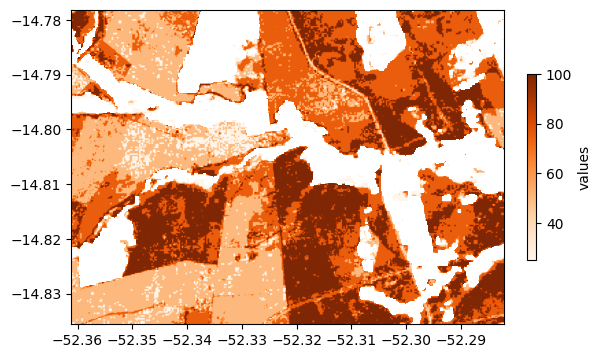

In [11]:
import numexpr as ne
import numpy as np

cultiv_gras_rules = [
    [ # Global Pasture Watch
        "(" 
            "(",
                "gpw_cultivgrassland_rfsavgol_p_30m_20180101_20181231 +",
                "gpw_cultivgrassland_rfsavgol_p_30m_20190101_20191231 +",
                "gpw_cultivgrassland_rfsavgol_p_30m_20200101_20201231 +",
                "gpw_cultivgrassland_rfsavgol_p_30m_20210101_20211231 +",
                "gpw_cultivgrassland_rfsavgol_p_30m_20220101_20221231",
            ") / 5",
        ") > 32"
    ],
    [ # GLAD GLCLUC
        "((lc_gladglcluc_c_30m_s_20200101_20201231 >= 6) & (lc_gladglcluc_c_30m_s_20200101_20201231 <= 24))",
        " | ",
        "((lc_gladglcluc_c_30m_s_20200101_20201231 >= 102) & (lc_gladglcluc_c_30m_s_20200101_20201231 <= 124))",
    ],
    [ # ESA WorldCover
       "(lc_esaworldcover_c_10m_s_20210101_20211231 == 30)"
    ], 
    [ #GLC_FCS30D
        "(",
            "((lc_glcfcs30d_c_30m_s_20180101_20181231 == 11) | (lc_glcfcs30d_c_30m_s_20180101_20181231 == 130)) & ",
            "((lc_glcfcs30d_c_30m_s_20190101_20191231 == 11) | (lc_glcfcs30d_c_30m_s_20190101_20191231 == 130)) & ",
            "((lc_glcfcs30d_c_30m_s_20200101_20201231 == 11) | (lc_glcfcs30d_c_30m_s_20200101_20201231 == 130)) & ",
            "((lc_glcfcs30d_c_30m_s_20210101_20211231 == 11) | (lc_glcfcs30d_c_30m_s_20210101_20211231 == 130)) & ",
            "((lc_glcfcs30d_c_30m_s_20220101_20221231 == 11) | (lc_glcfcs30d_c_30m_s_20220101_20221231 == 130))",
        ")",
    ]
]

i = 0
out_data[:,:,i] = ne.evaluate(rules2expr(cultiv_gras_rules), local_dict=local_dict).astype('float32')
out_data[out_data[:,:,i] == 0] = np.nan
plot_data(out_data[:,:,i], extent, cmap='Oranges')

## Natural/Semi-natural grassland 

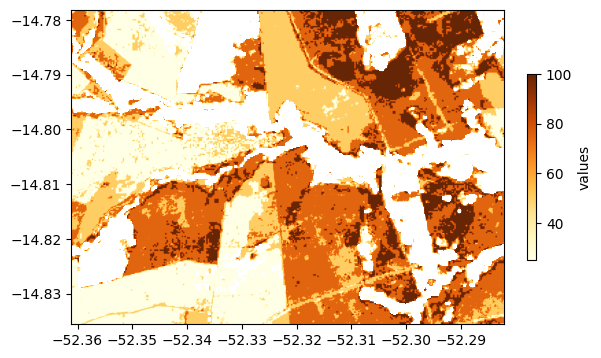

In [12]:
import numexpr as ne
import numpy as np

nat_gras_rules = [
    [ # Global Pasture Watch
        "(" 
            "(",
                "gpw_cultivgrassland_rfsavgol_p_30m_20180101_20181231 +",
                "gpw_cultivgrassland_rfsavgol_p_30m_20190101_20191231 +",
                "gpw_cultivgrassland_rfsavgol_p_30m_20200101_20201231 +",
                "gpw_cultivgrassland_rfsavgol_p_30m_20210101_20211231 +",
                "gpw_cultivgrassland_rfsavgol_p_30m_20220101_20221231",
            ") / 5",
        ") > 42"
    ],
    [ # GLAD GLCLUC
        "((lc_gladglcluc_c_30m_s_20200101_20201231 >= 6) & (lc_gladglcluc_c_30m_s_20200101_20201231 <= 24))",
        " | ",
        "((lc_gladglcluc_c_30m_s_20200101_20201231 >= 102) & (lc_gladglcluc_c_30m_s_20200101_20201231 <= 124))",
    ],
    [ # ESA WorldCover
       "(lc_esaworldcover_c_10m_s_20210101_20211231 == 30) |",
       "(lc_esaworldcover_c_10m_s_20210101_20211231 == 20)"
    ], 
    [ #GLC_FCS30D
        "(",
            "((lc_glcfcs30d_c_30m_s_20180101_20181231 >=120) & (lc_glcfcs30d_c_30m_s_20180101_20181231 <= 153)) | ",
            "((lc_glcfcs30d_c_30m_s_20190101_20191231 >=120) & (lc_glcfcs30d_c_30m_s_20190101_20191231 <= 153)) | ",
            "((lc_glcfcs30d_c_30m_s_20200101_20201231 >=120) & (lc_glcfcs30d_c_30m_s_20200101_20201231 <= 153)) | ",
            "((lc_glcfcs30d_c_30m_s_20210101_20211231 >=120) & (lc_glcfcs30d_c_30m_s_20210101_20211231 <= 153)) | ",
            "((lc_glcfcs30d_c_30m_s_20220101_20221231 >=120) & (lc_glcfcs30d_c_30m_s_20220101_20221231 <= 153))",
        ")",
    ]
]

i = 1
out_data[:,:,i] = ne.evaluate(rules2expr(nat_gras_rules), local_dict=local_dict).astype('float32')
out_data[out_data[:,:,i] == 0] = np.nan
plot_data(out_data[:,:,i], extent, cmap='YlOrBr')

## Cropland

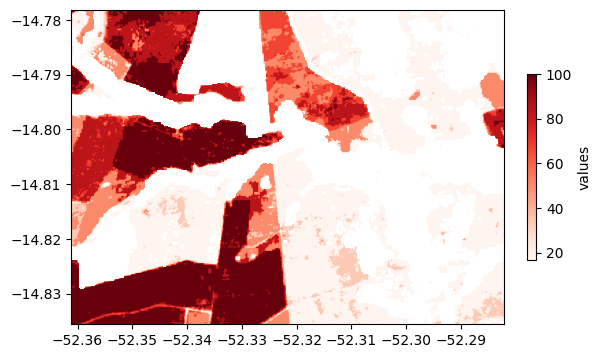

In [13]:
import numexpr as ne
import numpy as np

glcfcs_exp = "((lc_glcfcs30d_c_30m_s_20180101_20181231 == 20) | (lc_glcfcs30d_c_30m_s_20190101_20191231 == 20)  | (lc_glcfcs30d_c_30m_s_20200101_20201231 == 20) | (lc_glcfcs30d_c_30m_s_20210101_20211231 == 20) | (lc_glcfcs30d_c_30m_s_20220101_20221231 == 20))"
soybean_glad_exp = "((soybean_gladcropmap_c_30m_s_20180101_20181231 == 1) | (soybean_gladcropmap_c_30m_s_20190101_20191231 == 1)  | (soybean_gladcropmap_c_30m_s_20200101_20201231 == 1) | (soybean_gladcropmap_c_30m_s_20210101_20211231 == 1))"
lc_glad_exp = "(lc_gladglcluc_c_30m_s_20200101_20201231 == 244)"
crop_glad_exp = "(cropland_gladpotapovetal_p_30m_s_20190101_20191231 == 100)"
esa_cereal_exp = "(tempcrops_esaworldcereal_p_10m_s_20210101_20211231 > 50)"
esa_cover_exp = "(lc_esaworldcover_c_10m_s_20210101_20211231 == 40)"

cropland_rules = [
    [ # Soy cover of South America
        "(",
            "soybean_gladcropmap_c_30m_s_20180101_20181231 +",
            "soybean_gladcropmap_c_30m_s_20190101_20191231 +",
            "soybean_gladcropmap_c_30m_s_20200101_20201231 +",
            "soybean_gladcropmap_c_30m_s_20200101_20201231 +",
            "soybean_gladcropmap_c_30m_s_20210101_20211231",
        ") >= 1"
    ],
    [ # GLAD GLCLUC
        "(lc_gladglcluc_c_30m_s_20200101_20201231 == 244)",
    ],
    [ # Global cropland expansion
       "(cropland_gladpotapovetal_p_30m_s_20190101_20191231 == 100)"
    ],
    [ # ESA WorldCover
       "(lc_esaworldcover_c_10m_s_20210101_20211231 == 40)"
    ],
    [ # ESA WorldCereal
       "(tempcrops_esaworldcereal_p_10m_s_20210101_20211231 >= 50)"
    ],
    [ # GLC_FCS30D
        "(",
            "((lc_glcfcs30d_c_30m_s_20180101_20181231 >= 10) & (lc_glcfcs30d_c_30m_s_20180101_20181231 <= 20)) | ",
            "((lc_glcfcs30d_c_30m_s_20190101_20191231 >= 10) & (lc_glcfcs30d_c_30m_s_20190101_20191231 <= 20)) | ",
            "((lc_glcfcs30d_c_30m_s_20200101_20201231 >= 10) & (lc_glcfcs30d_c_30m_s_20200101_20201231 <= 20)) | ",
            "((lc_glcfcs30d_c_30m_s_20210101_20211231 >= 10) & (lc_glcfcs30d_c_30m_s_20210101_20211231 <= 20)) | ",
            "((lc_glcfcs30d_c_30m_s_20220101_20221231 >= 10) & (lc_glcfcs30d_c_30m_s_20220101_20221231 <= 20))",
        ")",
    ]
]

i = 2
out_data[:,:,i] = ne.evaluate(rules2expr(cropland_rules), local_dict=local_dict).astype('float32')
out_data[out_data[:,:,i] == 0] = np.nan
plot_data(out_data[:,:,i], extent, cmap='Reds')

## Agriculture classes

In [14]:
np.argmax(np.stack([
    (out_data[:,:,0] >= 50) * 1,
    (out_data[:,:,1] == 100) * 2,
    (out_data[:,:,2] >= 50) * 3,
    ], axis=-1), axis=-1)

array([[2, 2, 2, ..., 0, 0, 0],
       [2, 2, 2, ..., 0, 0, 0],
       [2, 2, 2, ..., 0, 0, 0],
       ...,
       [2, 2, 2, ..., 0, 0, 0],
       [2, 2, 2, ..., 0, 0, 0],
       [2, 2, 2, ..., 0, 0, 0]])

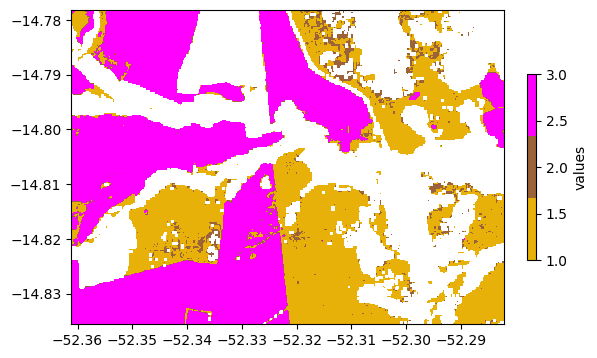

In [15]:
from matplotlib.colors import ListedColormap

colors = ListedColormap(["#e7b10a", "#9c633a", "#ff00ff"])

out_data[:,:,3] = np.amax(np.stack([
    (out_data[:,:,0] >= 50) * 1,
    (out_data[:,:,1] == 100) * 2,
    (out_data[:,:,2] >= 50) * 3,
], axis=-1), axis=-1)
out_data[out_data == 0] = np.nan

plot_data(out_data[:,:,3], extent, cmap=colors)

## Exporting layers

In [16]:
##### from skmap.io import save_rasters
out_file = [
    'cultiv.grassland_ensemb.lclu_p_30m_20180101_20221231_go_epsg.4326_v1.tif',
    'nat.semi.grassland_ensemb.lclu_p_30m_20180101_20221231_go_epsg.4326_v1.tif',
    'cropland_ensemb.lclu_p_30m_20180101_20221231_go_epsg.4326_v1.tif',
    'agriculture_ensemb.lclu_c_30m_20180101_20221231_go_epsg.4326_v1|.tif'
]

save_rasters(vrt_files[0], out_file, out_data, window=window, n_jobs=1, verbose=True)

[08:02:50] Saving 4 raster files using 1 workers


['cultiv.grassland_ensemb.lclu_p_30m_20180101_20221231_go_epsg.4326_v1.tif',
 'nat.semi.grassland_ensemb.lclu_p_30m_20180101_20221231_go_epsg.4326_v1.tif',
 'cropland_ensemb.lclu_p_30m_20180101_20221231_go_epsg.4326_v1.tif',
 'agriculture_ensemb.lclu_c_30m_20180101_20221231_go_epsg.4326_v1|.tif']